# Will a tropical storm make landfall?

## The source dataset

We will use the IBTrACS (International Best Track Archive for Climate Stewardship) tropical storm database hosted at NOAA: https://www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data. We will be using the NetCDF file that contains all storms. Since NetCDF is a self-describing format, info about the variables contained in this dataset can be instrospected. Additional info about the variables is located here: ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r08/wmo/netcdf/README.netcdf.

The class variable (prediction variable) will be determined from the dataset using the **landfall** variable:

```
    short landfall(storm, time) ;
        landfall:long_name = "Minimum distance to land until next report (0=landfall)" ;
        landfall:units = "km" ;
        landfall:_FillValue = -999s ;
```

In [1]:
import os, sys, re, json, arff
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
from ipyleaflet import Map, GeoJSON
from astropy.time import Time
from IPython.display import display, HTML


# get netcdf dataset
file = "Allstorms.ibtracs_wmo.v03r08.nc"
ds = NC.Dataset(file)

## Extract features

We will extract features the following features from this dataset:

* name (STRING)
* genesis_basin { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian }
* sub_basin of first observation { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian, 7 = AS - Arabian Sea, 8 = BB - Bay of Bengal, 9 = EA - Eastern Australia, 10 = WA - Western Australia, 11 = CP - Central Pacific, 12 = CS - Carribbean Sea, 13 = GM - Gulf of Mexico, 14 = MM - Missing }
* time of first observation (MJD value) (REAL)
* longitude of first observation (REAL)
* latitude of first observation (REAL)
* distance to land of first observation (REAL)
* msw (maximum sustained wind) of first observation (REAL)
* mcp (minimum central pressure) of first observation (REAL)
* storm nature { 0 = TS - Tropical, 1 = SS - Subtropical, 2 = ET - Extratropical, 3 = DS - Disturbance, 4 = MX - Mix of conflicting reports, 5 = NR - Not Reported, 6 = MM - Missing, 7 = - Missing }
* track_type { 0 = main - cylclogenesis to cyclolysis, 1 = merge - cyclogenesis to merger, 2 = split - split to cyclolysis, 3 = other - split to merger }
* made_landfall { TRUE, FALSE }

In [2]:
# define dict for discrete features
disc_map = {
    "basin": {
         0: "NA", # North Atlantic
         1: "SA", # South Atlantic
         2: "WP", # West Pacific
         3: "EP", # East Pacific
         4: "SP", # South Pacific
         5: "NI", # North Indian
         6: "SI", # South Indian
         7: "AS", # Arabian Sea
         8: "BB", # Bay of Bengal
         9: "EA", # Eastern Australia
        10: "WA", # Western Australia
        11: "CP", # Central Pacific
        12: "CS", # Carribbean Sea
        13: "GM", # Gulf of Mexico
        14: "MM", # Missing
    },
    "nature": {
        0: "TS",  # Tropical
        1: "SS",  # Subtropical
        2: "ET",  # Extratropical
        3: "DS",  # Disturbance
        4: "MX",  # Mix of conflicting reports
        5: "NR",  # Not Reported
        6: "MM",  # Missing
        7: "MM2", # Also Missing
    },
    "track_type": {
        0: "main",  # cyclogenesis to cyclolysis
        1: "merge", # cyclogenesis to merger
        2: "split", # split to cyclolysis
        3: "other", # split to merger
    }
}

# extract features from each hurricane and save into a list of dicts
data = []
landfall_count = 0

# compile regular expression for matching unnamed storms
unnamed_re = re.compile(r'(UNNAMED|NOT NAMED)')

for i in range(ds.dimensions['storm'].size):
    
    # get number of observations
    obs = ds.variables['numObs'][i]
    if obs <= 2: continue # skip if there are 2 or less observations
    
    # extract filterable features first
    name = np.array_str(NC.chartostring(ds.variables['name'][i,:]))[2:-1]
    genesis_basin = ds.variables['genesis_basin'][i]
    sub_basin = ds.variables['sub_basin'][i,:obs-1]
    nature = ds.variables['nature_wmo'][i:,obs-1]
    
    # skip records that have missing values in features
    if genesis_basin == 14:
        continue
    # skipping this filter; this filters out the east pacific storms
    #if sub_basin[0] == 14:
    #    continue
    if nature[0] in (4, 5, 6, 7):
        continue
        
    # skip records with unnamed storms
    if unnamed_re.search(name): continue
    
    # extract the rest of the features
    time = ds.variables['time_wmo'][i,:obs-1]
    time_iso = Time(time, format='mjd', scale='utc')
    
    # extract lon and handle wrapping issue
    lon = ds.variables['lon_wmo'][i,:obs-1]
    lon_diff = lon[0] - lon[-1]
    if lon_diff > 180.:
        lon[np.where(lon > 0)] -= 360.
    elif lon_diff < 180.:
        lon[np.where(lon < 0)] += 360.
        
    lat = ds.variables['lat_wmo'][i,:obs-1]
    dist2land = ds.variables['dist2land'][i,:obs-1]
    msw = ds.variables['wind_wmo'][i,:obs-1]
    mcp = ds.variables['pres_wmo'][i,:obs-1]
    tt = ds.variables['track_type'][i]
    landfall = (ds.variables['landfall'][i,:obs-1] == 0).any()
    
    # create GeoJSON of storm track
    ls = { 
        "type": "LineString",
        "coordinates": np.dstack((lon, lat))[0].tolist(),
    }
    
    # create feature for leaflet display;
    # stuff features into a message info for on_hover display
    msg = "{} {} {} {} {} {} {} {} {} {} {} {} {}".format(i, name, obs, genesis_basin, sub_basin[0],
                                                          time_iso[0].iso, lon[0], lat[0], dist2land[0],
                                                          msw[0], mcp[0], nature[0], tt, landfall)
    ls_feature = { 
        "type": "Feature",
        "properties": { "msg": msg },
        "geometry": ls,
    }
    
    # create data dict
    data.append({
        "name": name,
        "genesis_basin": disc_map['basin'][genesis_basin],
        "sub_basin": disc_map['basin'][sub_basin[0]],
        "time": time[0],
        "lon": lon[0],
        "lat": lat[0],
        "dist2land": dist2land[0],
        "msw": msw[0],
        "mcp": mcp[0],
        "nature": disc_map['nature'][nature[0]],
        "track_type": disc_map['track_type'][tt],
        "landfall": landfall,
        "feature": ls_feature,
    })
    
    # tally landfall
    if landfall: landfall_count += 1
    
# print tally
print("total storms: {}".format(len(data)))
print("hit landfall: {}".format(landfall_count))

# create data frame
df = pd.DataFrame(data)

total storms: 3636
hit landfall: 1655


In [3]:
display(df[['name', 'genesis_basin', 'sub_basin', 'time', 'lon', 'lat', 'dist2land', 'msw',
            'mcp', 'nature', 'track_type', 'landfall']])

,name,genesis_basin,sub_basin,time,lon,lat,dist2land,msw,mcp,nature,track_type,landfall
0,HIKI,EP,CP,33505.00,215.500000,14.500000,1229,25.0,0.0,TS,main,False
1,ABLE,NA,NA,33505.00,304.500000,17.100000,930,35.0,0.0,ET,main,True
2,BAKER,NA,NA,33511.50,306.000000,12.000000,683,30.0,0.0,TS,main,True
3,CHARLIE,NA,NA,33514.50,333.600006,11.099999,1045,35.0,0.0,ET,main,False
4,DOG,NA,NA,33523.75,304.399994,15.200000,772,80.0,0.0,ET,main,True
5,EASY,NA,CS,33525.25,276.799988,19.699999,194,40.0,0.0,TS,main,True
6,FOX,NA,NA,33532.25,319.000000,15.500000,1686,40.0,0.0,ET,main,False
7,GEORGE,NA,NA,33551.25,309.000000,24.600000,1660,35.0,0.0,ET,main,False
8,HOW,NA,GM,33555.25,271.600006,25.599998,385,30.0,0.0,TS,main,True
9,ITEM,NA,GM,33562.25,269.600006,23.299999,240,35.0,0.0,TS,main,True


## Generate random sampling of each prediction (class) value and generate ARFF file

In [7]:
# randomly sample 500 records of each class value
landfall_sample = df.loc[df['landfall'] == True].sample(500)
nolandfall_sample = df.loc[df['landfall'] == False].sample(500)

# generate ARFF file
arff_data = {
    "relation": "tropicalstorms",
    "description": "IBTrACS (International Best Track Archive for Climate Stewardship) tropical storm database",
    "attributes": [
        ("genesis_basin", ["NA", "SA", "WP", "EP", "SP", "NI", "SI"]),
        ("nature", ["TS", "SS", "ET", "DS"]),
        ("track_type", ["main", "merge", "split", "other"]),
        #("time", "DATE"),
        ("lon", "REAL"),
        ("lat", "REAL"),
        ("dist2land", "REAL"),
        ("msw", "REAL"),
        ("mcp", "REAL"),
        ("landfall", ["True", "False"]),
    ],
    "data": [],
}
for r in landfall_sample.itertuples():
    arff_data['data'].append([r.genesis_basin, r.nature, r.track_type,
                              #Time(r.time, format='mjd', scale='utc'),
                              r.lon, r.lat, r.dist2land, r.msw,
                              r.mcp, r.landfall]) 
for r in nolandfall_sample.itertuples():
    arff_data['data'].append([r.genesis_basin, r.nature, r.track_type,
                              #Time(r.time, format='mjd', scale='utc'),
                              r.lon, r.lat, r.dist2land, r.msw,
                              r.mcp,  r.landfall]) 
with open('tropicalstorms.arff', 'w') as f:
    arff.dump(arff_data, f)

## Visualize the dataset storms tracks

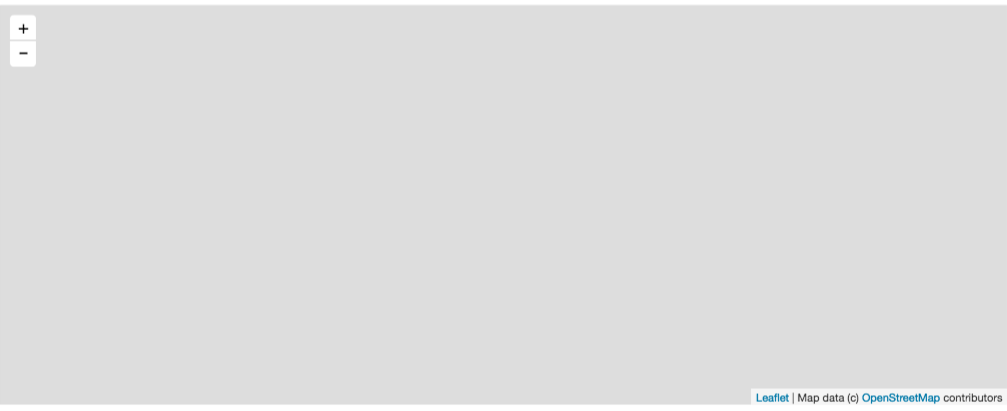

6380 EWINIAR 66 2 14 2006-06-29 06:00:00.000 139.8000030517578 6.0 870 0.0 1006.0 2 0

In [10]:
# set styles
landfall_style = {
    "color": "red",
    "weight": 1,
}
nolandfall_style = {
    "color": "green",
    "weight": 1,
}
hover_style = {
    "weight": 5,
}

# hover handler
def hover_handler(event=None, id=None, properties=None):
    sys.stdout.write("\r" + properties['msg'])
    sys.stdout.flush()

# show map    
m = Map(center=[0, 180], zoom=2)
m

In [11]:
# add tracks storms that made landfall
for r in landfall_sample.itertuples():
    l = GeoJSON(data=r.feature, style=landfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    

In [12]:
# add tracks storms that didn't make landfall
for r in nolandfall_sample.itertuples():
    l = GeoJSON(data=r.feature, style=nolandfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    